In [1]:
!git clone https://github.com/Kemsekov/kemsekov_torch

fatal: destination path 'kemsekov_torch' already exists and is not an empty directory.


2283 


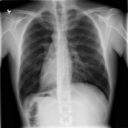

In [2]:
# load dataset for diffusion model to learn
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import random
from kemsekov_torch.train import split_dataset
import torchvision.transforms as T

# if some images have alpha we replace it with zeros
def process_alpha_image(img):
    # Open the image and convert to RGB from RGBA
    img_array = np.array(img)
    if len(img_array.shape)<3: return img
    if img_array.shape[-1]<4: 
        return img
    # Split into channels
    r, g, b, a = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2], img_array[:, :, 3]
    
    # Set RGB to 0 where alpha is 0
    r[a == 0] = 0
    g[a == 0] = 0
    b[a == 0] = 0
    
    # Create new RGB image array
    new_img_array = np.dstack((r, g, b)).astype(np.uint8)
    
    # Convert back to PIL Image and return
    return PIL.Image.fromarray(new_img_array)

class JustImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, image_transform=None):
        super().__init__()
        allowed_formats = ['.png', '.jpg', '.jpeg', '.webp']
        self.images = []
        for root, _, files in os.walk(images_folder):
            self.images.extend(os.path.join(root, v) for v in files if any([v.endswith(f) for f in allowed_formats]))
        self.transform = nn.Identity() if image_transform is None else image_transform
        
    def __getitem__(self, index):
        im = self.images[index]
        im = PIL.Image.open(im)
        im = process_alpha_image(im)
        im = self.transform(im)
        return im, ''
    
    def __len__(self): return len(self.images)

# if some images are grayscale we map them to grayscale rgb
def add_dim(x):
    if len(x.shape)<3: return x[None,:][[0,0,0]]
    if x.shape[0]==1: return x[[0,0,0]]
    return x

IM_SIZE=128
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.Resize(IM_SIZE),
    T.RandomCrop((IM_SIZE,IM_SIZE)),
    T.Lambda(add_dim)
])

PATH_TO_IMAGES='/home/vlad/Documents/image-classification/lungs_normal/'
dataset = JustImagesDataset(PATH_TO_IMAGES,transform)

batch_size=32
train_dataset,test_dataset,train_loader, test_loader = split_dataset(dataset,batch_size=batch_size,test_size=0.05)

ind = random.randint(0,len(dataset)-1)
# ind = 315
im,desc = dataset[ind]
print(ind,desc)
display(T.ToPILImage()(im))

In [3]:
# define diffusion model
from kemsekov_torch.diffusion import DiffusionUtils, sample
from kemsekov_torch.residual import Residual, ResidualBlock
from kemsekov_torch.attention import LinearSelfAttentionBlock, FlattenSpatialDimensions
from kemsekov_torch.rotary_emb import RotaryEmbInplace
from kemsekov_torch.positional_emb import ConcatPositionalEmbeddingPermute, PositionalEncodingPermute

class TimeContextEmbedding(torch.nn.Module):
    def __init__(self,in_channels,dimensions=2,max_timesteps=1024):
        """
        Layer that combines input x and timestep .
        
        in_channels: input channels
        
        dimensions: input/context spatial dimensions count
        
        max_timesteps: this parameter defines max timestep input value.
        """
        super().__init__()
        self.combine_x_time = [nn.Conv1d,nn.Conv2d,nn.Conv3d][dimensions-1](2*in_channels,in_channels,kernel_size=1)
        x=torch.randn((1,in_channels,max_timesteps,1))
        time = PositionalEncodingPermute(in_channels,freq=max_timesteps)(x)
        time = time[0].transpose(0,1)[...,0]
        self.time_emb = torch.nn.Parameter(time)
        
    def forward(self,x,timestep):
        """
        x: input of shape (B,C,...) where ... is spatial dimensions
        timestep: long tensor of shape (B). It is a timestep for each element in batch.
        """
        time = self.time_emb[timestep.cpu()].to(x.device)
        dims = list(time.shape)+[1]*(len(x.shape)-2)
        time=time.view(dims).expand_as(x)
        x_t = self.combine_x_time(torch.concat([x,time],1))
        return x_t

class DiffusionBlock(torch.nn.Module):
    """
    Diffusion unet block, that combines downsample/upsample operation and linear transformer blocks
    """
    def __init__(self,in_channels,out_channels,transformer_blocks = 0,residual_blocks=2,attn_heads=8,max_timesteps=64,normalization='batch',dimensions=2):
        super().__init__()
        mlp_dim=out_channels*2
        self.down = ResidualBlock(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            dimensions=dimensions,
            normalization=normalization,
        )
        
        self.residual_blocks = Residual(
            [
                ResidualBlock(
                    out_channels,
                    [mlp_dim,out_channels],
                    kernel_size=3,
                    stride=1,
                    dimensions=dimensions,
                    normalization=normalization,
                )
                for i in range(residual_blocks)
            ]
        )
        
        self.embed_context_to_down = TimeContextEmbedding(out_channels,dimensions,max_timesteps)
        if transformer_blocks>0:
            # add self attention with rotary embedding optimized for pixel data
            self.sa = Residual([
                RotaryEmbInplace(out_channels,freqs_for='pixel'),
                FlattenSpatialDimensions([
                    LinearSelfAttentionBlock(out_channels,mlp_dim,attn_heads)
                    for i in range(transformer_blocks)
                ])
            ])
        else:
            self.sa = torch.nn.Identity()
        
    def forward(self,x,time):
        xt = self.down(x)
        xt = self.embed_context_to_down(xt,time)
        xt = self.sa(xt)
        xt = self.residual_blocks(xt)
        return xt
    
    def transpose(self):
        self.down = self.down.transpose()
        return self

class Diffusion(torch.nn.Module):
    def __init__(self, in_channels,max_timesteps=1024):
        super().__init__()
        
        common = dict(
            normalization='batch',
            attn_heads = 16,
            dimensions = 2,
            max_timesteps=max_timesteps,
            residual_blocks=2,
            
        )
        scale = 1
        self.dimensions = common['dimensions']
        self.in_channels=in_channels
        self.down1 = DiffusionBlock(in_channels,64*scale,transformer_blocks=1,**common)
        self.down2 = DiffusionBlock(64*scale,128*scale,transformer_blocks=1,**common )
        self.down3 = DiffusionBlock(128*scale,256*scale,transformer_blocks=2,**common)
        self.down4 = DiffusionBlock(256*scale,512*scale,transformer_blocks=2,**common)
        
        self.up1 = DiffusionBlock(512*scale,256*scale,**common).transpose()
        self.merge_up1_down3 = nn.Conv2d(512*scale,256*scale,kernel_size=1)
        
        self.up2 = DiffusionBlock(256*scale,128*scale,**common).transpose()
        self.merge_up2_down2 = nn.Conv2d(256*scale,128*scale,kernel_size=1)
        
        self.up3 = DiffusionBlock(128*scale,64*scale,**common).transpose()
        self.merge_up3_down1 = nn.Conv2d(128*scale,64*scale,kernel_size=1)

        self.up4 = DiffusionBlock(64*scale,64*scale,**common).transpose()
        
        # to produce proper logits, combine model output that input
        self.final = nn.Sequential(
            [torch.nn.Conv1d,torch.nn.Conv2d,torch.nn.Conv3d][self.dimensions-1](64*scale,in_channels,kernel_size=1)
        )
    
    # x is batched single example with all noise levels
    # timestep is indices of noise levels for each sample is x
    # context_embedding is batched tensor with
    def forward(self,x, timestep : torch.LongTensor):
        """
        x: [batch,channels,width,height]
        
        timestep: [batch] tensor of type long
        """
        d1 = self.down1(x,timestep)
        
        d2 = self.down2(d1,timestep)
        d3 = self.down3(d2,timestep)
        d4 = self.down4(d3,timestep)
        
        u1 = self.up1(d4,timestep)
        u1 = self.merge_up1_down3(torch.concat([u1,d3],1))
        
        u2 = self.up2(u1,timestep)
        u2 = self.merge_up2_down2(torch.concat([u2,d2],1))
        
        u3 = self.up3(u2,timestep)
        u3 = self.merge_up3_down1(torch.concat([u3,d1],1))
        
        u4 = self.up4(u3,timestep)
        
        return self.final(u4)
    
in_channels = 3
# show example how to use it
s = torch.randn((2,in_channels,256,256)) # input noised images
timestep = torch.LongTensor([3,2]) #timestep indices
diff = Diffusion(in_channels,max_timesteps=512)
denoised = sample(diff,(1,in_channels,32,32),128)
pred_noise = diff(s,timestep)

In [4]:
# compute dataset images mean and std, so we can better rescale inputs to diffusion model
means = []
stds = []
for b in train_loader:
    im = b[0]
    dims = [-1,-2]
    mean = im.mean(dims,keepdim=True).mean(0)
    std = im.std(dims,keepdim=True).mean(0)
    means.append(mean)
    stds.append(std)

images_mean,images_std = torch.stack(means).mean(0),torch.stack(stds).mean(0)
images_mean.flatten(),images_std.flatten()

(tensor([0.5042, 0.5042, 0.5042]), tensor([0.2253, 0.2253, 0.2253]))

In [5]:
from kemsekov_torch.train import *
import warnings
warnings.filterwarnings("ignore")

def r2_score(predictions: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Computes the R² (coefficient of determination) metric.

    Args:
        predictions (torch.Tensor): Predicted values tensor.
        targets (torch.Tensor): Actual target values tensor.

    Returns:
        float: R² score representing how well the predictions approximate the targets.
    """
    # Compute the total sum of squares (variance of the target)
    target_mean = torch.mean(targets)
    total_variance = torch.sum((targets - target_mean) ** 2)
    
    # Compute the residual sum of squares128
    residual_variance = torch.sum((targets - predictions) ** 2)
    
    # Calculate the R² score
    r2 = 1 - (residual_variance / total_variance)
    
    return r2.item()

timesteps=128
diff_util = DiffusionUtils(timesteps)

def compute_loss_and_metric(model,batch):
    image,desc = batch
    image=(image-images_mean.to(image.device))/images_std.to(image.device)
    time = torch.randint(0,timesteps-1,(len(image),))
    noised_samples,noise = diff_util.diffusion_forward(image,time)
    pred_noise = model(noised_samples,time)
    
    loss = torch.mean((pred_noise-noise)**2)
    return loss,{
        'r2':r2_score(pred_noise,noise),
    }

# it works better without scheduler 
epochs = 100
optim = torch.optim.AdamW(diff.parameters(),lr=1e-3)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim,len(train_loader)*epochs)

path = "runs/diffusion"
_ = train(
    diff,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    path,
    # os.path.join(path,'last'),
    scheduler=sch,
    optimizer=optim,
    gradient_clipping_max_norm=1,
    accelerate_args={
        'mixed_precision':'bf16',
        'dynamo_backend':'inductor', #painfully slow starts
        # 'gradient_accumulation_steps':4
    },
    save_on_metric_improve=['r2'],
    num_epochs=epochs,
)

Total model parameters 50.65 M
trying to capture model architecture...
Saved model architecture at runs/diffusion/model.pt. You can torch.load it and update it's weights with checkpoint

Epoch 1/100


train 0: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=0.0470, r2=0.9532]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.30173 | 0.19951 |
|  r2  | 0.6984  | 0.8005  |
+------+---------+---------+
saved epoch-1

Epoch 2/100


train 0:   1%|▏         | 1/75 [00:35<44:22, 35.98s/it, loss=0.1884, r2=0.8113]W0616 01:28:08.258000 3801162 torch/_dynamo/convert_frame.py:906] [6/8] torch._dynamo hit config.cache_size_limit (8)
W0616 01:28:08.258000 3801162 torch/_dynamo/convert_frame.py:906] [6/8]    function: 'forward' (/home/vlad/Cardio/tmp/Image-Diffusion/kemsekov_torch/residual.py:30)
W0616 01:28:08.258000 3801162 torch/_dynamo/convert_frame.py:906] [6/8]    last reason: 6/0: tensor 'L['x']' dtype mismatch. expected BFloat16, actual Float
W0616 01:28:08.258000 3801162 torch/_dynamo/convert_frame.py:906] [6/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0616 01:28:08.258000 3801162 torch/_dynamo/convert_frame.py:906] [6/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
train 0: 100%|██████████| 75/75 [00:53<00:00,  1.41it/s, loss=0.0895, r2=0.9106]
W0616 01:28:24.413000 3801162 torch/_dynamo/convert_frame.py:906] [4/8] torch._dynamo hi

+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.14589 | 0.10609 |
|  r2  | 0.8541  | 0.8940  |
+------+---------+---------+
saved epoch-2

Epoch 3/100


train 0: 100%|██████████| 75/75 [00:12<00:00,  5.77it/s, loss=0.0865, r2=0.9136]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08594 | 0.07953 |
|  r2  | 0.9141  | 0.9204  |
+------+---------+---------+
saved epoch-3

Epoch 4/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0585, r2=0.9413]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.06682 | 0.06497 |
|  r2  | 0.9332  | 0.9350  |
+------+---------+---------+
saved epoch-4

Epoch 5/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0570, r2=0.9431]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0575 | 0.05836 |
|  r2  | 0.9425 | 0.9416  |
+------+--------+---------+
saved epoch-5

Epoch 6/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.77it/s, loss=0.0536, r2=0.9462]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.05154 | 0.06567 |
|  r2  | 0.9485  | 0.9344  |
+------+---------+---------+

Epoch 7/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.77it/s, loss=0.0464, r2=0.9537]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.05417 | 0.05279 |
|  r2  | 0.9458  | 0.9472  |
+------+---------+---------+
saved epoch-7

Epoch 8/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0297, r2=0.9702]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.05311 | 0.04759 |
|  r2  | 0.9469  | 0.9524  |
+------+---------+---------+
saved epoch-8

Epoch 9/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.1031, r2=0.8972]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04967 | 0.04747 |
|  r2  | 0.9504  | 0.9526  |
+------+---------+---------+
saved epoch-9

Epoch 10/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0250, r2=0.9750]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04769 | 0.05259 |
|  r2  | 0.9523  | 0.9474  |
+------+---------+---------+

Epoch 11/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0805, r2=0.9196]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04261 | 0.03099 |
|  r2  | 0.9574  | 0.9690  |
+------+---------+---------+
saved epoch-11

Epoch 12/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.48it/s, loss=0.0356, r2=0.9644]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04899 | 0.03169 |
|  r2  | 0.9510  | 0.9683  |
+------+---------+---------+

Epoch 13/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0349, r2=0.9652]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.04157 | 0.0463 |
|  r2  | 0.9584  | 0.9537 |
+------+---------+--------+

Epoch 14/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0217, r2=0.9782]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04049 | 0.05221 |
|  r2  | 0.9595  | 0.9478  |
+------+---------+---------+

Epoch 15/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0340, r2=0.9660]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04238 | 0.04644 |
|  r2  | 0.9576  | 0.9536  |
+------+---------+---------+

Epoch 16/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.1684, r2=0.8317]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04442 | 0.05239 |
|  r2  | 0.9556  | 0.9476  |
+------+---------+---------+

Epoch 17/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0177, r2=0.9823]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04022 | 0.04964 |
|  r2  | 0.9598  | 0.9504  |
+------+---------+---------+

Epoch 18/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0733, r2=0.9268]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.03947 | 0.0502 |
|  r2  | 0.9605  | 0.9498 |
+------+---------+--------+

Epoch 19/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0563, r2=0.9435]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0397 | 0.04854 |
|  r2  | 0.9603 | 0.9515  |
+------+--------+---------+

Epoch 20/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0283, r2=0.9717]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04198 | 0.03427 |
|  r2  | 0.9580  | 0.9658  |
+------+---------+---------+

Epoch 21/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0404, r2=0.9595]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04148 | 0.04539 |
|  r2  | 0.9585  | 0.9546  |
+------+---------+---------+

Epoch 22/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0259, r2=0.9742]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03936 | 0.04574 |
|  r2  | 0.9606  | 0.9542  |
+------+---------+---------+

Epoch 23/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0193, r2=0.9807]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03895 | 0.04477 |
|  r2  | 0.9610  | 0.9552  |
+------+---------+---------+

Epoch 24/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.3407, r2=0.6598]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04413 | 0.03915 |
|  r2  | 0.9559  | 0.9609  |
+------+---------+---------+

Epoch 25/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0799, r2=0.9202]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.04075 | 0.04039 |
|  r2  | 0.9592  | 0.9596  |
+------+---------+---------+

Epoch 26/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0202, r2=0.9797]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03595 | 0.03973 |
|  r2  | 0.9640  | 0.9603  |
+------+---------+---------+

Epoch 27/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0372, r2=0.9629]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03779 | 0.04248 |
|  r2  | 0.9622  | 0.9575  |
+------+---------+---------+

Epoch 28/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0500, r2=0.9501]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03649 | 0.04833 |
|  r2  | 0.9635  | 0.9517  |
+------+---------+---------+

Epoch 29/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0191, r2=0.9809]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03681 | 0.04257 |
|  r2  | 0.9632  | 0.9574  |
+------+---------+---------+

Epoch 30/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0273, r2=0.9728]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03591 | 0.02482 |
|  r2  | 0.9641  | 0.9752  |
+------+---------+---------+
saved epoch-30

Epoch 31/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.50it/s, loss=0.0197, r2=0.9803]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03922 | 0.02351 |
|  r2  | 0.9608  | 0.9765  |
+------+---------+---------+
saved epoch-31

Epoch 32/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0371, r2=0.9628]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03845 | 0.03786 |
|  r2  | 0.9616  | 0.9621  |
+------+---------+---------+

Epoch 33/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0192, r2=0.9807]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03759 | 0.04084 |
|  r2  | 0.9624  | 0.9592  |
+------+---------+---------+

Epoch 34/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.76it/s, loss=0.0548, r2=0.9452]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03666 | 0.06137 |
|  r2  | 0.9633  | 0.9386  |
+------+---------+---------+

Epoch 35/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0438, r2=0.9561]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03708 | 0.04967 |
|  r2  | 0.9629  | 0.9504  |
+------+---------+---------+

Epoch 36/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0206, r2=0.9794]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03486 | 0.06549 |
|  r2  | 0.9651  | 0.9345  |
+------+---------+---------+

Epoch 37/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0242, r2=0.9758]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03437 | 0.02305 |
|  r2  | 0.9656  | 0.9769  |
+------+---------+---------+
saved epoch-37

Epoch 38/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0207, r2=0.9794]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03699 | 0.03197 |
|  r2  | 0.9630  | 0.9680  |
+------+---------+---------+

Epoch 39/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0150, r2=0.9850]


+------+--------+--------+
|      | Train  |  Test  |
+------+--------+--------+
| loss | 0.0332 | 0.0554 |
|  r2  | 0.9668 | 0.9446 |
+------+--------+--------+

Epoch 40/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0484, r2=0.9517]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03916 | 0.04973 |
|  r2  | 0.9608  | 0.9503  |
+------+---------+---------+

Epoch 41/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0446, r2=0.9556]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03614 | 0.03768 |
|  r2  | 0.9639  | 0.9623  |
+------+---------+---------+

Epoch 42/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0322, r2=0.9677]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03325 | 0.03699 |
|  r2  | 0.9668  | 0.9630  |
+------+---------+---------+

Epoch 43/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0317, r2=0.9682]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03784 | 0.03085 |
|  r2  | 0.9622  | 0.9691  |
+------+---------+---------+

Epoch 44/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.1529, r2=0.8469]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03596 | 0.05035 |
|  r2  | 0.9640  | 0.9496  |
+------+---------+---------+

Epoch 45/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0190, r2=0.9810]


+------+--------+--------+
|      | Train  |  Test  |
+------+--------+--------+
| loss | 0.0331 | 0.0237 |
|  r2  | 0.9669 | 0.9763 |
+------+--------+--------+

Epoch 46/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.0184, r2=0.9815]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03533 | 0.03593 |
|  r2  | 0.9647  | 0.9641  |
+------+---------+---------+

Epoch 47/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0152, r2=0.9847]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03198 | 0.04327 |
|  r2  | 0.9680  | 0.9568  |
+------+---------+---------+

Epoch 48/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.75it/s, loss=0.1097, r2=0.8900]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03695 | 0.02669 |
|  r2  | 0.9630  | 0.9733  |
+------+---------+---------+

Epoch 49/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0219, r2=0.9781]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03476 | 0.03619 |
|  r2  | 0.9652  | 0.9638  |
+------+---------+---------+

Epoch 50/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0224, r2=0.9775]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03045 | 0.03596 |
|  r2  | 0.9695  | 0.9641  |
+------+---------+---------+

Epoch 51/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0553, r2=0.9446]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03292 | 0.03016 |
|  r2  | 0.9671  | 0.9698  |
+------+---------+---------+

Epoch 52/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.46it/s, loss=0.0346, r2=0.9655]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03688 | 0.03422 |
|  r2  | 0.9631  | 0.9658  |
+------+---------+---------+

Epoch 53/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0222, r2=0.9779]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03608 | 0.04095 |
|  r2  | 0.9639  | 0.9591  |
+------+---------+---------+

Epoch 54/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0213, r2=0.9788]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03082 | 0.03971 |
|  r2  | 0.9692  | 0.9603  |
+------+---------+---------+

Epoch 55/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0234, r2=0.9766]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03571 | 0.03736 |
|  r2  | 0.9643  | 0.9626  |
+------+---------+---------+

Epoch 56/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0185, r2=0.9815]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03579 | 0.04273 |
|  r2  | 0.9642  | 0.9573  |
+------+---------+---------+

Epoch 57/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0286, r2=0.9713]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03525 | 0.03413 |
|  r2  | 0.9648  | 0.9659  |
+------+---------+---------+

Epoch 58/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0305, r2=0.9696]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03028 | 0.02894 |
|  r2  | 0.9697  | 0.9711  |
+------+---------+---------+

Epoch 59/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0194, r2=0.9806]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03133 | 0.02472 |
|  r2  | 0.9687  | 0.9753  |
+------+---------+---------+

Epoch 60/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0268, r2=0.9731]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03119 | 0.02851 |
|  r2  | 0.9688  | 0.9715  |
+------+---------+---------+

Epoch 61/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0627, r2=0.9370]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.02989 | 0.04204 |
|  r2  | 0.9701  | 0.9580  |
+------+---------+---------+

Epoch 62/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0109, r2=0.9891]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03328 | 0.04123 |
|  r2  | 0.9667  | 0.9588  |
+------+---------+---------+

Epoch 63/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0354, r2=0.9646]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03172 | 0.03362 |
|  r2  | 0.9683  | 0.9664  |
+------+---------+---------+

Epoch 64/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0126, r2=0.9874]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0335 | 0.03311 |
|  r2  | 0.9665 | 0.9669  |
+------+--------+---------+

Epoch 65/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0165, r2=0.9834]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03132 | 0.02499 |
|  r2  | 0.9687  | 0.9750  |
+------+---------+---------+

Epoch 66/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0235, r2=0.9766]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03206 | 0.04606 |
|  r2  | 0.9679  | 0.9540  |
+------+---------+---------+

Epoch 67/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0159, r2=0.9841]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0335 | 0.03482 |
|  r2  | 0.9665 | 0.9652  |
+------+--------+---------+

Epoch 68/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0358, r2=0.9642]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03113 | 0.03515 |
|  r2  | 0.9689  | 0.9648  |
+------+---------+---------+

Epoch 69/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0397, r2=0.9603]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03496 | 0.04039 |
|  r2  | 0.9650  | 0.9596  |
+------+---------+---------+

Epoch 70/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.74it/s, loss=0.0198, r2=0.9802]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03436 | 0.05163 |
|  r2  | 0.9656  | 0.9484  |
+------+---------+---------+

Epoch 71/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0203, r2=0.9797]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03191 | 0.03374 |
|  r2  | 0.9681  | 0.9663  |
+------+---------+---------+

Epoch 72/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0165, r2=0.9835]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03494 | 0.04337 |
|  r2  | 0.9651  | 0.9567  |
+------+---------+---------+

Epoch 73/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0415, r2=0.9586]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03079 | 0.02193 |
|  r2  | 0.9692  | 0.9781  |
+------+---------+---------+
saved epoch-73

Epoch 74/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0125, r2=0.9875]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.02951 | 0.03754 |
|  r2  | 0.9705  | 0.9625  |
+------+---------+---------+

Epoch 75/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.44it/s, loss=0.0234, r2=0.9766]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03434 | 0.04313 |
|  r2  | 0.9657  | 0.9569  |
+------+---------+---------+

Epoch 76/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0292, r2=0.9707]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.03053 | 0.0325 |
|  r2  | 0.9695  | 0.9675 |
+------+---------+--------+

Epoch 77/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0202, r2=0.9798]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03178 | 0.03296 |
|  r2  | 0.9682  | 0.9671  |
+------+---------+---------+

Epoch 78/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0151, r2=0.9849]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.02833 | 0.0332 |
|  r2  | 0.9717  | 0.9668 |
+------+---------+--------+

Epoch 79/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.70it/s, loss=0.0168, r2=0.9832]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03174 | 0.03218 |
|  r2  | 0.9683  | 0.9678  |
+------+---------+---------+

Epoch 80/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0103, r2=0.9897]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03085 | 0.02595 |
|  r2  | 0.9692  | 0.9740  |
+------+---------+---------+

Epoch 81/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0275, r2=0.9725]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03292 | 0.01707 |
|  r2  | 0.9671  | 0.9829  |
+------+---------+---------+
saved epoch-81

Epoch 82/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0151, r2=0.9849]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.02902 | 0.03398 |
|  r2  | 0.9710  | 0.9660  |
+------+---------+---------+

Epoch 83/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.1598, r2=0.8400]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03362 | 0.04278 |
|  r2  | 0.9664  | 0.9572  |
+------+---------+---------+

Epoch 84/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0220, r2=0.9780]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.02929 | 0.03398 |
|  r2  | 0.9707  | 0.9660  |
+------+---------+---------+

Epoch 85/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0269, r2=0.9730]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03138 | 0.04506 |
|  r2  | 0.9686  | 0.9550  |
+------+---------+---------+

Epoch 86/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.70it/s, loss=0.0146, r2=0.9854]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03338 | 0.02482 |
|  r2  | 0.9666  | 0.9752  |
+------+---------+---------+

Epoch 87/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0166, r2=0.9834]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03095 | 0.03051 |
|  r2  | 0.9690  | 0.9695  |
+------+---------+---------+

Epoch 88/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0111, r2=0.9889]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.03445 | 0.036  |
|  r2  | 0.9655  | 0.9640 |
+------+---------+--------+

Epoch 89/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0369, r2=0.9631]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.03089 | 0.0206 |
|  r2  | 0.9691  | 0.9794 |
+------+---------+--------+

Epoch 90/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0171, r2=0.9829]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.02945 | 0.0282 |
|  r2  | 0.9706  | 0.9718 |
+------+---------+--------+

Epoch 91/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.70it/s, loss=0.0130, r2=0.9870]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.02751 | 0.02207 |
|  r2  | 0.9725  | 0.9779  |
+------+---------+---------+

Epoch 92/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0252, r2=0.9749]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03135 | 0.02138 |
|  r2  | 0.9686  | 0.9786  |
+------+---------+---------+

Epoch 93/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.73it/s, loss=0.0253, r2=0.9747]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03097 | 0.02025 |
|  r2  | 0.9690  | 0.9798  |
+------+---------+---------+

Epoch 94/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0149, r2=0.9850]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.02962 | 0.02301 |
|  r2  | 0.9704  | 0.9770  |
+------+---------+---------+

Epoch 95/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0461, r2=0.9538]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03322 | 0.02284 |
|  r2  | 0.9668  | 0.9772  |
+------+---------+---------+

Epoch 96/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0165, r2=0.9835]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03185 | 0.02169 |
|  r2  | 0.9681  | 0.9783  |
+------+---------+---------+

Epoch 97/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.70it/s, loss=0.0250, r2=0.9751]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03153 | 0.02728 |
|  r2  | 0.9685  | 0.9727  |
+------+---------+---------+

Epoch 98/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.72it/s, loss=0.0551, r2=0.9449]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03416 | 0.05259 |
|  r2  | 0.9659  | 0.9474  |
+------+---------+---------+

Epoch 99/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.71it/s, loss=0.0173, r2=0.9828]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.03419 | 0.03114 |
|  r2  | 0.9658  | 0.9689  |
+------+---------+---------+

Epoch 100/100


train 0: 100%|██████████| 75/75 [00:13<00:00,  5.40it/s, loss=0.0508, r2=0.9493]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0298 | 0.02258 |
|  r2  | 0.9702 | 0.9774  |
+------+--------+---------+


In [70]:
diff = torch.jit.load(os.path.join(path,'model.pt'))
diff=load_checkpoint(diff,path,-1)
# diff=load_last_checkpoint(diff,path)
diff=diff.eval().cuda().float()

loading runs/diffusion/checkpoints/epoch-81/state


tensor(0.1564) tensor(0.9112)


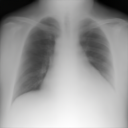

In [86]:
inference_timesteps = 64
# torch.random.manual_seed(1)
pred = sample(diff,(1,in_channels,128,128),128,inference_timesteps,regenerate_noise=True,normalize_pred=True).cpu()#.sigmoid()
print(pred.mean(),pred.std())
pred-=pred.min()
pred/=pred.max()
T.ToPILImage()(pred[0])